## **ECS7001: NN and NLP**

**Sparsh Verma 220996233**

## **Part A**

In [1]:
!pip install numpy==1.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.6.8 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.


In [2]:
!wget http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
!unzip '/content/hahackathon_data.zip'

--2023-04-23 23:57:04--  http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
Resolving smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)... 129.215.10.97
Connecting to smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)|129.215.10.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571603 (558K) [application/zip]
Saving to: ‘hahackathon_data.zip’

hahackathon_data.zi 100%[===================>] 558.21K  1.03MB/s    in 0.5s    

2023-04-23 23:57:05 (1.03 MB/s) - ‘hahackathon_data.zip’ saved [571603/571603]

Archive:  /content/hahackathon_data.zip
   creating: hahackathon data/
  inflating: hahackathon data/.DS_Store  
  inflating: __MACOSX/hahackathon data/._.DS_Store  
  inflating: hahackathon data/test.csv  
  inflating: __MACOSX/hahackathon data/._test.csv  
  inflating: hahackathon data/dev.csv  
  inflating: __MACOSX/hahackathon data/._dev.csv  
  inflating: hahackathon data/train.csv  
  inflating: __MACOSX/hahackathon data/._train.csv  


In [3]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q  ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import argparse
import random

In [7]:
def set_random_seed(seed=123):
  random.seed(seed)
  np.random.seed(seed)

set_random_seed()

In [8]:
from transformers import DistilBertTokenizer
import tqdm

# we will pad to 128 subword tokens
PAD_LENGTH = 128
bert = 'distilbert-base-uncased'
BATCH_SIZE = 512
EPOCHS =10

# Defining DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert, do_lower_case=True, add_special_tokens=True, 
                                                max_length=PAD_LENGTH, padding='max_length', truncation=True)

def tokenize(sentences, tokenizer, pad_length=PAD_LENGTH):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True,  
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
 
    return (np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32'))

In [9]:
import pandas as pd

# Load data with only the necessary columns
train_df = pd.read_csv('hahackathon data/train.csv', usecols = ['text','humor_rating','offense_rating'])
test_df = pd.read_csv('hahackathon data/test.csv', usecols = ['text','humor_rating','offense_rating'])

# Drop the Nans
train_df = train_df.dropna()
test_df = test_df.dropna()

In [10]:
train_df

,text,humor_rating,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,2.42,0.20
1,A man inserted an advertisement in the classif...,2.50,1.10
2,How many men does it take to open a can of bee...,1.95,2.40
3,Told my mom I hit 1200 Twitter followers. She ...,2.11,0.00
4,Roses are dead. Love is fake. Weddings are bas...,2.78,0.10
...,...,...,...
7991,"Sins are like viruses, it's better you keep th...",2.13,0.10
7993,My daughter wanted a Cinderella themed birthda...,3.70,0.00
7996,Why are aspirins white? Because they work sorry,1.33,3.85
7997,"Today, we Americans celebrate our independence...",2.55,0.00


In [11]:
# Get the post text
train_examples_list = train_df['text'].tolist()
test_examples_list = test_df['text'].tolist()

# Get the humour rating for the regression task (we normalise, the values are between 0 and 5)
train_targets_list = (train_df['humor_rating']/5).tolist()
test_targets_list = (test_df['humor_rating']/5).tolist()

In [12]:
def get_bert_inputs(examples_list, targets):
  input_ids=list()
  attention_masks=list()

  bert_inp=tokenize(examples_list, tokenizer)
  input_ids = bert_inp[0]
  attention_masks = bert_inp[1]

  targets = np.array(targets)

  return input_ids, attention_masks, targets

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)

In [15]:
from transformers import TFDistilBertModel, DistilBertConfig
from tensorflow.keras.layers import GlobalAveragePooling1D, Input, Dense
import tensorflow as tf
 

class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def compute_mask(self, inputs, mask=None):
        return None
    def call(self, x, mask=None):
        if mask is not None:
            mask = tf.cast(mask, tf.float32)
            mask = tf.expand_dims(mask, axis=-1)
            x = x * mask
        return super().call(x) 

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)

def create_regression_BoW_bert():
  input_ids = Input(shape=(PAD_LENGTH,), dtype=tf.int32, name="input_ids")
  input_masks_ids = Input(shape=(PAD_LENGTH,), dtype=tf.int32, name="input_masks_ids")

  bert_layer = get_BERT_layer()
  bert_layer.trainable = False
  bert_out = bert_layer(input_ids, attention_mask=input_masks_ids)[0]
  bert_out = GlobalAveragePooling1DMasked()(bert_out)
  out_reg = Dense(1, activation='sigmoid')(bert_out)

  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs=[out_reg])

def get_model(use_tpu=True, use_gpu=False, learning_rate=2e-5):
  if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model on TPU:
    with strategy.scope():
      model = create_regression_BoW_bert()
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.losses.MeanSquaredError()])
  elif use_gpu:
    device_name = tf.test.gpu_device_name()
    print(device_name)
    with tf.device('/device:GPU:0'):
      model = create_regression_BoW_bert()
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.losses.MeanSquaredError()])
  else:
    model = create_regression_BoW_bert()
    model.compile(optimizer='adam',
                loss='mse',
                metrics=[tf.keras.losses.MeanSquaredError()])
  return model

model = get_model(use_tpu=True, use_gpu=False, learning_rate=2e-5)

Running on TPU  grpc://10.65.180.42:8470


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 input_masks_ids (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_masks_ids[0][0]']        
                                one, 128, 768),                                                   
                                 hidden_states=None                                           

In [17]:
history = model.fit([train_input_ids, train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/10
10/10 [==============================] - 24s 496ms/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 2/10
10/10 [==============================] - 1s 78ms/step - loss: 0.0156 - mean_squared_error: 0.0156
Epoch 3/10
10/10 [==============================] - 1s 79ms/step - loss: 0.0153 - mean_squared_error: 0.0154
Epoch 4/10
10/10 [==============================] - 1s 78ms/step - loss: 0.0150 - mean_squared_error: 0.0149
Epoch 5/10
10/10 [==============================] - 1s 73ms/step - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 6/10
10/10 [==============================] - 1s 73ms/step - loss: 0.0145 - mean_squared_error: 0.0146
Epoch 7/10
10/10 [==============================] - 1s 77ms/step - loss: 0.0143 - mean_squared_error: 0.0144
Epoch 8/10
10/10 [==============================] - 1s 72ms/step - loss: 0.0142 - mean_squared_error: 0.0143
Epoch 9/10
10/10 [==============================] - 1s 73ms/step - loss: 0.0141 - mean_squared_error: 0.0142
Epoch 10/10
10/10

In [18]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test MSE:', results[1])

20/20 [==============================] - 10s 126ms/step - loss: 0.0150 - mean_squared_error: 0.0146
Test loss: 0.014973544515669346
Test MSE: 0.014620913192629814


In [19]:
preds = model.predict(
      [test_input_ids,test_attention_masks],
      batch_size=None,
      verbose="auto",
      steps=None,
      callbacks=None,
      max_queue_size=10,
      workers=1,
      use_multiprocessing=False)

preds = np.array(preds).flatten()

20/20 [==============================] - 8s 279ms/step


In [20]:
min(preds), max(preds), preds.mean()

(0.38814443, 0.55575144, 0.47146443)

In [21]:
min(test_targets), max(test_targets), test_targets.mean()

(0.054000000000000006, 0.6839999999999999, 0.42383414634146344)

<Axes: >

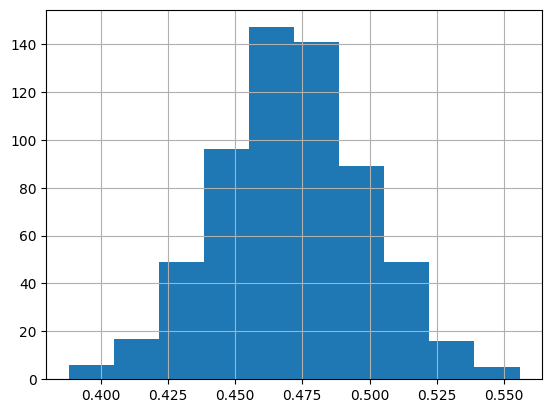

In [22]:
pd.Series(preds).hist()

<Axes: >

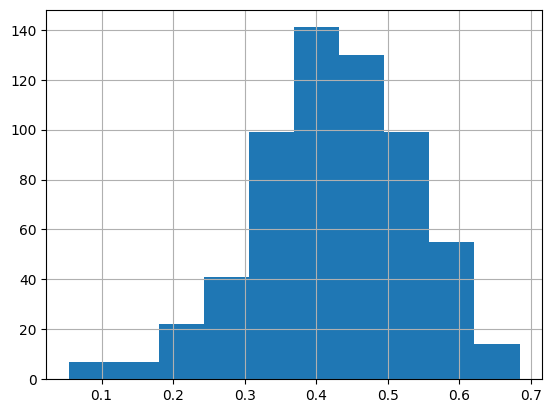

In [23]:
pd.Series(test_targets).hist()

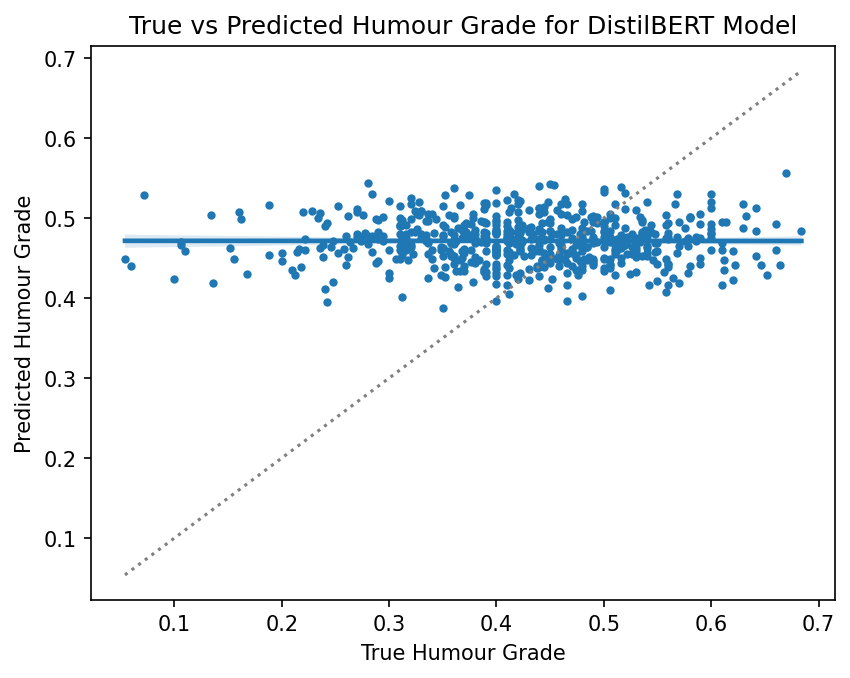

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
def get_pred_true_plot(preds, labels, title):
    limits = [labels.min(), labels.max()]
    fig, ax = plt.subplots()
    fig.set_dpi(150)
    ax.set_title(title)
    ax.scatter(labels, preds, marker='.')
    ax.plot(limits, limits, color="gray", linestyle=":")
    ax.set_xlabel('True Humour Grade')
    ax.set_ylabel('Predicted Humour Grade')
    sns.regplot(x=labels, y=preds, ax=ax, scatter_kws={"s": 5})
    plt.show()

get_pred_true_plot(preds, test_targets, 'True vs Predicted Humour Grade for DistilBERT Model')

In [25]:
!pip install -q ekphrasis
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.9/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.9/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


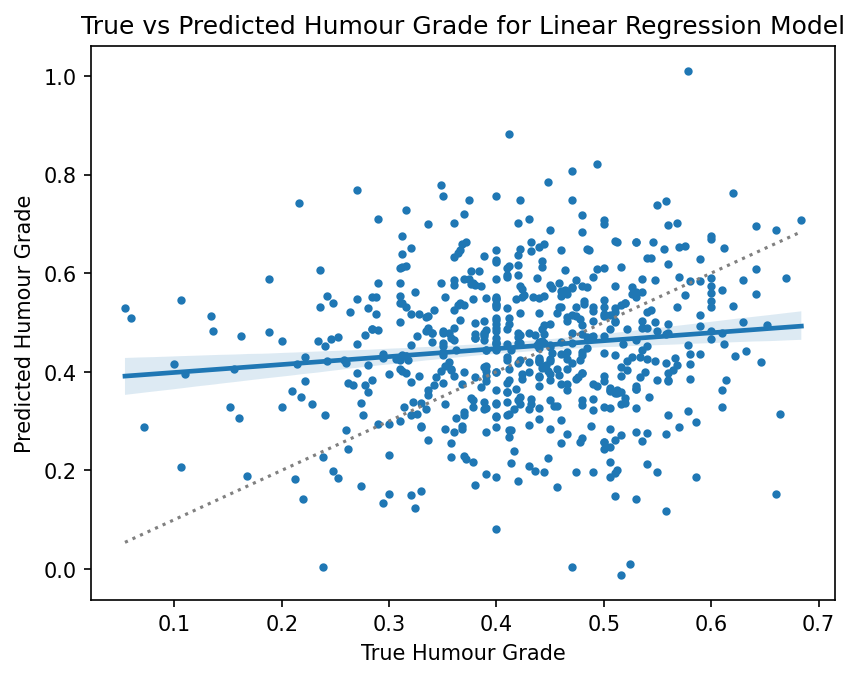

In [26]:
from ekphrasis.classes.segmenter import Segmenter
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.classes.spellcorrect import SpellCorrector
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
                'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)
new_train_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in train_examples_list]
new_test_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in test_examples_list]

new_train_examples_list[0]

new_test_examples_list[0]

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(new_train_examples_list)
X_train_counts.shape

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

X_test_counts = count_vect.transform(new_test_examples_list)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train_tfidf, train_targets)
preds = reg.predict(X_test_tfidf)
mean_squared_error(test_targets, preds)

get_pred_true_plot(preds, test_targets, 'True vs Predicted Humour Grade for Linear Regression Model')


In [31]:
print("Original Text:", train_examples_list[0])
print("Preprocessed Text:", new_train_examples_list[0])

Original Text: TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit...
Preprocessed Text: <allcaps> tennessee </allcaps> : we are the best state . nobody even comes close . * elevennessee walks into the room * <allcaps> tennessee </allcaps> : oh shit . <repeated>


In [32]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(new_train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(new_test_examples_list, test_targets_list)
 
model = get_model()
history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Running on TPU  grpc://10.65.180.42:8470


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
10/10 [==============================] - 21s 508ms/step - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 2/10
10/10 [==============================] - 1s 72ms/step - loss: 0.0163 - mean_squared_error: 0.0162
Epoch 3/10
10/10 [==============================] - 1s 72ms/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 4/10
10/10 [==============================] - 1s 72ms/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 5/10
10/10 [==============================] - 1s 72ms/step - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 6/10
10/10 [==============================] - 1s 72ms/step - loss: 0.0156 - mean_squared_error: 0.0156
Epoch 7/10
10/10 [==============================] - 1s 72ms/step - loss: 0.0156 - mean_squared_error: 0.0155
Epoch 8/10
10/10 [==============================] - 1s 77ms/step - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 9/10
10/10 [==============================] - 1s 72ms/step - loss: 0.0154 - mean_squared_error: 0.0153
Epoch 10/10
10/10

In [33]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test MSE:', results[1])

20/20 [==============================] - 10s 131ms/step - loss: 0.0148 - mean_squared_error: 0.0143
Test loss: 0.01475684903562069
Test MSE: 0.014312131330370903


In [34]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.0 MB/s eta 0:00:00


In [36]:
# Get the data again to apply augmentation
train_df = pd.read_csv('hahackathon data/train.csv')
test_df = pd.read_csv('hahackathon data/test.csv')

train_df.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [38]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

def augment_data(df, aug, col_name):
    aug_df = df.copy()
    aug_df[col_name] = aug_df[col_name].apply(lambda x: aug.augment(x))
    return pd.concat([df, aug_df], ignore_index=True)

aug = naw.SynonymAug(aug_src='wordnet')
aug_df = augment_data(train_df, aug, 'text')
aug_df.head()

train_examples_list = aug_df['text'].tolist()
train_targets_list = (aug_df['humor_rating']/5).tolist()

test_examples_list = test_df['text'].tolist()
test_targets_list = (test_df['humor_rating']/5).tolist()

# new_train_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in train_examples_list]
# new_test_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in test_examples_list]


In [39]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)

In [40]:
print("Training examples before augmentation:")
print(len(train_df['text'].tolist()))
print("Training examples after augmentation:")
print(len(train_examples_list))

Training examples before augmentation:
8000
Training examples after augmentation:
16000


In [41]:
model = get_model()
history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Running on TPU  grpc://10.65.180.42:8470


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
32/32 [==============================] - 23s 194ms/step - loss: nan - mean_squared_error: nan
Epoch 2/10
32/32 [==============================] - 2s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 3/10
32/32 [==============================] - 2s 71ms/step - loss: nan - mean_squared_error: nan
Epoch 4/10
32/32 [==============================] - 2s 73ms/step - loss: nan - mean_squared_error: nan
Epoch 5/10
32/32 [==============================] - 2s 71ms/step - loss: nan - mean_squared_error: nan
Epoch 6/10
32/32 [==============================] - 2s 74ms/step - loss: nan - mean_squared_error: nan
Epoch 7/10
32/32 [==============================] - 2s 73ms/step - loss: nan - mean_squared_error: nan
Epoch 8/10
32/32 [==============================] - 2s 73ms/step - loss: nan - mean_squared_error: nan
Epoch 9/10
32/32 [==============================] - 2s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 10/10
32/32 [==============================] - 2s 73ms/step - los

In [42]:
results = model.evaluate([np.asarray(test_input_ids),np.asarray(test_attention_masks)], test_targets)
print('Test loss:', results[0])
print('Test MSE:', results[1])

32/32 [==============================] - 9s 92ms/step - loss: nan - mean_squared_error: nan
Test loss: nan
Test MSE: nan


In [43]:
# Get the train data again to avoid any confusion
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()
 
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)

In [44]:
RERUNS = 3
# We save the predictions of each model to the list
all_model_preds = list()

for i in range(RERUNS):
  set_random_seed(seed=random.randint(0, 500))

  # Your code goes here
  model = get_model()
  history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)
  
  preds = model.predict(
      [test_input_ids,test_attention_masks],
      batch_size=None,
      verbose="auto",
      steps=None,
      callbacks=None,
      max_queue_size=10,
      workers=1,
      use_multiprocessing=False)
  
  all_model_preds.append(np.array(preds).flatten())


Running on TPU  grpc://10.65.180.42:8470


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
16/16 [==============================] - 21s 343ms/step - loss: nan - mean_squared_error: nan
Epoch 2/10
16/16 [==============================] - 1s 74ms/step - loss: nan - mean_squared_error: nan
Epoch 3/10
16/16 [==============================] - 1s 73ms/step - loss: nan - mean_squared_error: nan
Epoch 4/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 5/10
16/16 [==============================] - 1s 73ms/step - loss: nan - mean_squared_error: nan
Epoch 6/10
16/16 [==============================] - 1s 75ms/step - loss: nan - mean_squared_error: nan
Epoch 7/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 8/10
16/16 [==============================] - 1s 73ms/step - loss: nan - mean_squared_error: nan
Epoch 9/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 10/10
32/32 [==============================] - 9s 190ms/step
Runn

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
16/16 [==============================] - 21s 333ms/step - loss: nan - mean_squared_error: nan
Epoch 2/10
16/16 [==============================] - 1s 74ms/step - loss: nan - mean_squared_error: nan
Epoch 3/10
16/16 [==============================] - 1s 73ms/step - loss: nan - mean_squared_error: nan
Epoch 4/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 5/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 6/10
16/16 [==============================] - 1s 73ms/step - loss: nan - mean_squared_error: nan
Epoch 7/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 8/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 9/10
16/16 [==============================] - 1s 71ms/step - loss: nan - mean_squared_error: nan
Epoch 10/10
32/32 [==============================] - 8s 185ms/step
Runn

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
16/16 [==============================] - 22s 335ms/step - loss: nan - mean_squared_error: nan
Epoch 2/10
16/16 [==============================] - 1s 75ms/step - loss: nan - mean_squared_error: nan
Epoch 3/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 4/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 5/10
16/16 [==============================] - 1s 71ms/step - loss: nan - mean_squared_error: nan
Epoch 6/10
16/16 [==============================] - 1s 75ms/step - loss: nan - mean_squared_error: nan
Epoch 7/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 8/10
16/16 [==============================] - 1s 72ms/step - loss: nan - mean_squared_error: nan
Epoch 9/10
16/16 [==============================] - 1s 71ms/step - loss: nan - mean_squared_error: nan
Epoch 10/10
32/32 [==============================] - 9s 185ms/step


In [50]:
set_random_seed()

from transformers import TFDistilBertModel, DistilBertConfig

def create_TFBertMultitask():
  MAX_LEN = 100
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
  input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
  input_masks_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_masks_ids")
  bert_output = bert_model(input_ids, attention_mask=input_masks_ids)[0]
  bert_output = tf.keras.layers.Dropout(0.2)(bert_output)
  bert_output = tf.keras.layers.GlobalAveragePooling1D()(bert_output)
  out_reg1 = tf.keras.layers.Dense(1, activation='sigmoid', name='out_reg1')(bert_output)
  out_reg2 = tf.keras.layers.Dense(1, activation='sigmoid', name='out_reg2')(bert_output)

  # comment to run a single-task model
  # return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = [out_reg1, out_reg2])
  # uncomment to run a single-task model
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = [out_reg1])

use_tpu = True
use_gpu = False
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFBertMultitask()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    # comment to run a single-task model
    # model.compile(optimizer=optimizer, loss={'out_reg1': 'mse', 
    #                      'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 
    #                       'out_reg2': 'mse'})
    # uncomment to run a single-task model
    model.compile(optimizer=optimizer, loss={'out_reg1': 'mse'}, metrics={'out_reg1': 'mse'})
  
elif use_gpu:
  device_name = tf.test.gpu_device_name()
  print(device_name)
  with tf.device('/device:GPU:0'):
    model = create_TFBertMultitask()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss={'out_reg1': 'mse', 
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 
                          'out_reg2': 'mse'})
else:
  model = create_TFBertMultitask()
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
  model.compile(optimizer=optimizer, loss={'out_reg1': 'mse', 
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 
                          'out_reg2': 'mse'})


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [51]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 input_masks_ids (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 tf_distil_bert_model_9 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_masks_ids[0][0]']        
                                one, 100, 768),                                                   
                                 hidden_states=None                                         

## **Part B**

In [1]:
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dropout,Dense,GRU,Bidirectional
import numpy as np
import json,time,collections,random

In [2]:
class NERModel(object):
  def __init__(self,embedding_path, embedding_size,ner_labels):
    self.embedding_path = embedding_path
    self.embedding_size = embedding_size
    self.embedding_dropout_rate = 0.5
    self.hidden_size = 50
    self.ffnn_layer = 2
    self.hidden_dropout_rate = 0.2
    self.embedding_dict = self.load_embeddings()
    self.ner_labels = ner_labels
    self.ner_labels_mappings = {l:i for i,l in enumerate(ner_labels)}

  def load_embeddings(self):
    print("Loading word embeddings from {}...".format(self.embedding_path))
    embeddings = collections.defaultdict(lambda: np.zeros(self.embedding_size))
    for line in open(self.embedding_path):
      splitter = line.find(' ')
      emb = np.fromstring(line[splitter + 1:], np.float32, sep=' ')
      assert len(emb) == self.embedding_size
      embeddings[line[:splitter]] = emb
    print("Finished loading word embeddings")
    return embeddings

  def build(self):
    word_embeddings = Input(shape=(None,self.embedding_size,))
    word_embeddings = Dropout(self.embedding_dropout_rate)(word_embeddings)
    """
    Task 1 Create a two layer Bidirectional GRU and Multi-layer FFNN to compute the ner scores for individual tokens
    The shape of the ner_scores is [batch_size, max_sentence_length, number_of_ner_labels]
    """
    ner_scores = Bidirectional(GRU(self.hidden_size,return_sequences=True))(word_embeddings)
    ner_scores = Dropout(self.hidden_dropout_rate)(ner_scores)
    ner_scores = Bidirectional(GRU(self.hidden_size,return_sequences=True))(ner_scores)
    ner_scores = Dropout(self.hidden_dropout_rate)(ner_scores)

    for i in range(self.ffnn_layer):
      ner_scores = Dense(self.hidden_size,activation='relu')(ner_scores)
      ner_scores = Dropout(self.hidden_dropout_rate)(ner_scores)

    ner_scores = Dense(len(self.ner_labels),activation='softmax')(ner_scores)
    """
    End Task 1 
    """
    self.model = Model(inputs=[word_embeddings],outputs=ner_scores)
    self.model.compile(optimizer='adam',loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    self.model.summary()



  def get_feed_dict_list(self, path,batch_size):
    feed_dict_list = []
    data_sets = json.loads(open(path).readlines()[0])
    sentences = data_sets['sentences']
    ners = data_sets['ners']
    for i in range(0,len(sentences),batch_size):
      batch_start, batch_end = i, min(i+batch_size, len(sentences))
      sent_lengths = [len(sent) for sent in sentences[batch_start:batch_end]]
      max_sent_length = max(sent_lengths)

      word_emb = np.zeros([len(sent_lengths), max_sent_length, self.embedding_size])
      for i, sent in enumerate(sentences[batch_start:batch_end]):
        for j, word in enumerate(sent):
          word_emb[i, j] = self.embedding_dict[word.lower()]

      word_ner_labels = np.zeros([len(sent_lengths), max_sent_length])
      gold_named_entities = set()
      for i, ner in enumerate(ners[batch_start:batch_end]):
        for s,e,l in ner:
          l_id = self.ner_labels_mappings[l]
          gold_named_entities.add((i,s,e,l_id))
          for j in range(s,e+1):
            word_ner_labels[i,j] = l_id


      feed_dict_list.append((
        word_emb,
        word_ner_labels,
        gold_named_entities,
        sent_lengths
      ))

    return feed_dict_list


  def batch_generator(self, fd_list):
    random.shuffle(fd_list)
    for word_embeddings, word_ner_labels, _, _ in fd_list:
      yield [word_embeddings], word_ner_labels

  def train(self, train_path, dev_path, test_path, epochs,batch_size=100):
    train_fd_list = self.get_feed_dict_list(train_path,batch_size)
    print("Load {} training batches from {}".format(len(train_fd_list), train_path))

    dev_fd_list = self.get_feed_dict_list(dev_path,batch_size)
    print("Load {} dev batches from {}".format(len(dev_fd_list), dev_path))

    test_fd_list = self.get_feed_dict_list(test_path,batch_size)
    print("Load {} test batches from {}".format(len(test_fd_list), test_path))

    start_time = time.time()
    for epoch in range(epochs):
      print("\nStarting training epoch {}/{}".format(epoch + 1, epochs))
      epoch_time = time.time()

      self.model.fit(self.batch_generator(train_fd_list), steps_per_epoch=len(train_fd_list))

      print("Time used for epoch {}: {}".format(epoch + 1, self.time_used(epoch_time)))
      dev_time = time.time()
      print("Evaluating on dev set after epoch {}/{}:".format(epoch + 1, epochs))
      self.eval(dev_fd_list)
      print("Time used for evaluate on dev set: {}".format(self.time_used(dev_time)))

    print("\nTraining finished!")
    print("Time used for training: {}".format(self.time_used(start_time)))

    print("\nEvaluating on test set:")
    test_time = time.time()
    self.eval(test_fd_list)
    print("Time used for evaluate on test set: {}".format(self.time_used(test_time)))

  def eval(self, eval_fd_list):
    tp, fn, fp = 0,0,0
    for word_embeddings, _, gold,sent_lens in eval_fd_list:
      predictions = self.model.predict_on_batch([word_embeddings])

      """
      Task 2 create the predictions of NER from the IO label 
      e.g. 
      0 I         O
      1 met       O
      2 John      PER
      3 this      O
      4 afternoon O
      should give you a person NE John (x,2,2,1)
      where x is the sentence id in the batch, and 2,2 are the start and end indices of the NE,
      1 is the id for 'PER'    
      """
      tp_temp, fn_temp, fp_temp = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
      tp, fn, fp = 0,0,0
      count = [0,0,0,0,0]
      for word_embeddings, _, gold,sent_lens in eval_fd_list:
        predictions = self.model.predict_on_batch([word_embeddings])
        pred = np.argmax(predictions,2)
        for g_truth in gold:
          sent_id = g_truth[0]
          sent_len = sent_lens[sent_id]
          word_start = g_truth[1]
          word_end = g_truth[2]
          ner_label = g_truth[3]
          sent_pred = pred[sent_id]
          word_start_pred = pred[sent_id][word_start]
          word_end_pred = pred[sent_id][word_end]
          pred_true = True if ner_label == word_start_pred and ner_label == word_end_pred else False
          count[ner_label] = count[ner_label] + 1
          if pred_true:
            tp_temp[ner_label] = tp_temp[ner_label] + 1 
          else: 
            fn_temp[ner_label] = fn_temp[ner_label] + 1
            fp_temp[word_start_pred] = fp_temp[word_start_pred] + 1

      tp = np.sum(np.multiply(tp_temp,count))
      fn = np.sum(np.multiply(fn_temp,count))
      fp = np.sum(np.multiply(fp_temp,count))

      """
      End Task 2
      """

    p = 0.0 if tp == 0 else tp*1.0/(tp+fp)
    r = 0.0 if tp == 0 else tp*1.0/(tp+fn)
    f = 0.0 if tp == 0 else 2*p*r/(p+r)
    print("F1 : {:.2f}%".format(f * 100))
    print("Precision: {:.2f}%".format(p * 100))
    print("Recall: {:.2f}%".format(r * 100))

  def time_used(self, start_time):
    curr_time = time.time()
    used_time = curr_time - start_time
    m = used_time // 60
    s = used_time - 60 * m
    return "%d m %d s" % (m, s)

In [4]:
if __name__ == '__main__':
  embedding_path = 'glove.6B.100d.txt.ner.filtered'
  train_path = 'train.conll03.json'
  dev_path = 'dev.conll03.json'
  test_path = 'test.conll03.json'
  ner_labels = ['O', 'PER', 'ORG', 'LOC', 'MISC']
  embedding_size = 100
  model = NERModel(embedding_path,embedding_size, ner_labels)
  model.build()
  model.train(train_path,dev_path,test_path,5)

Loading word embeddings from glove.6B.100d.txt.ner.filtered...
Finished loading word embeddings
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 100)]       0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 100)        45600     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 100)        45600     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                               

## **Part C**

In [46]:
#Setting the URL link for the coreference files
%env url_coref=https://collect.qmul.ac.uk/down?t=5DBIRDID7VO84D2C/4P63FA4B9R6A4LLML77Q21O

env: url_coref=https://collect.qmul.ac.uk/down?t=5DBIRDID7VO84D2C/4P63FA4B9R6A4LLML77Q21O


In [47]:
#Downloading the coref_files.zip 
!wget $url_coref -O coref_files.zip

--2023-04-24 06:24:36--  https://collect.qmul.ac.uk/down?t=5DBIRDID7VO84D2C/4P63FA4B9R6A4LLML77Q21O
Resolving collect.qmul.ac.uk (collect.qmul.ac.uk)... 161.23.16.251
Connecting to collect.qmul.ac.uk (collect.qmul.ac.uk)|161.23.16.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘coref_files.zip’

coref_files.zip         [ <=>                ]   2.92K  --.-KB/s    in 0s      

2023-04-24 06:24:37 (204 MB/s) - ‘coref_files.zip’ saved [2987]



In [59]:
#Extracting the coref_files.zip
!unzip -q "coref_files.zip"

In [60]:
# IMPORTANT change this to the path to your folder. Remember to start from the home directory, 'My Drive'
PATH_TO_FOLDER = "coref_files/"

In [61]:
import sys
sys.path.append(PATH_TO_FOLDER)

In [62]:
DEV_PATH = PATH_TO_FOLDER + 'dev.jsonl'
TEST_PATH = PATH_TO_FOLDER + 'test.jsonl'
TRAIN_PATH = PATH_TO_FOLDER + 'train.jsonl'

EMBEDDING_PATH = PATH_TO_FOLDER + 'word_embeddings.filtered.txt'

In [63]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
%%capture

from keras import Input,Model
from keras import backend as K
from keras.layers import Dropout,Dense,LSTM,Bidirectional,Lambda,Reshape
import numpy as np
import tensorflow as tf
import json,time,collections,random
from sklearn import metrics

#seed everything
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [66]:
# the dimension of the pretrained embeddings
EMBEDDING_SIZE = 300

In [67]:
def load_embeddings(embedding_path=EMBEDDING_PATH, embedding_size=EMBEDDING_SIZE):
    print("Loading word embeddings from {}...".format(embedding_path))
    embeddings = collections.defaultdict(lambda: np.zeros(embedding_size))
    for line in open(embedding_path):
        splitter = line.find(' ')
        emb = np.fromstring(line[splitter + 1:], np.float32, sep=' ')
        assert len(emb) == embedding_size
        embeddings[line[:splitter]] = emb
    print("Finished loading word embeddings")
    print("Number of words: " + str(len(embeddings)))
    return embeddings

In [68]:
EMBEDDING_DICT = load_embeddings() 

Loading word embeddings from coref_files/word_embeddings.filtered.txt...
Finished loading word embeddings
Number of words: 4675


In [69]:
dummy_dataset = [{'doc_key': 'large_cat',
                  'sentences':[['The', 'large', 'cat', 'yawned', '.'],
                               ['He','was', 'very', 'hungry', 'as', 'he', 'had', 'not', 'eaten', 'since', 'breakfast','.'],
                               ['An', 'unfortunate', 'rat', 'came', 'along', '.'],
                               ['The', 'cat', 'gobbled', 'him', 'up', '.']],
                  'clusters': [[[0, 2], [5, 5], [10, 10], [23, 24]], [[17, 19], [26, 26]]]
                }]


sents = [w for sent in dummy_dataset[0]['sentences'] for w in sent]
print('These are the clusters in %s' %dummy_dataset[0]['doc_key'])
for cl_idx, cl in enumerate(dummy_dataset[0]['clusters']):
    print('Cluster ' + str(cl_idx) + ':', [' '.join(sents[s: e+1])  for s, e in cl])

These are the clusters in large_cat
Cluster 0: ['The large cat', 'He', 'he', 'The cat']
Cluster 1: ['An unfortunate rat', 'him']


In [70]:
def get_mentions(clusters):

    # get a list of mentions (as tuples) sorted by start indices.
    gold_mentions = sorted([tuple(m) for cl in clusters for m in cl])

    # number of mentions
    num_mentions = len(gold_mentions)

    # assign unique indices to each mention in the mention list based on its position in the list
    gold_mention_map = {m: i for i, m in enumerate(gold_mentions)}

    # assign cluster ids to each mention in order E.g. cluser_ids = [4, 11, 5, 4, ..] => mention 0 is in cluster 4
    # along with mention 3.
    cluster_ids = [0]*num_mentions
    for cid, cluster in enumerate(clusters):
        for mention in cluster:
            cluster_ids[gold_mention_map[tuple(mention)]] = cid

    return gold_mentions, gold_mention_map, cluster_ids, num_mentions

In [71]:
dmentions, dment_map, dcluster_ids, dnum_mentions = get_mentions(dummy_dataset[0]['clusters'])
print('These are all the coreferent mentions in the sample document ', dmentions)
print('These are the mentions mapped to unique ids denoting their order in the document ', dment_map)
print('These are the cluster ids of the ordered mentions', dcluster_ids)
print('There are %d mentions in the document titled \'%s\'' %(dnum_mentions, dummy_dataset[0]['doc_key']))

These are all the coreferent mentions in the sample document  [(0, 2), (5, 5), (10, 10), (17, 19), (23, 24), (26, 26)]
These are the mentions mapped to unique ids denoting their order in the document  {(0, 2): 0, (5, 5): 1, (10, 10): 2, (17, 19): 3, (23, 24): 4, (26, 26): 5}
These are the cluster ids of the ordered mentions [0, 0, 0, 1, 0, 1]
There are 6 mentions in the document titled 'large_cat'


In [72]:
def tensorize_doc_sentences(sentences, mentions):
    starts, ends = [],[]
    sent_lengths = [len(sent) for sent in sentences]  # the actual, unpadded length of each sentence
    max_sent_length = max(sent_lengths)

    # by padding each sentence to the maximum length, the embedded document will a new dimension
    embedded_sentences = np.zeros([1, len(sentences), max_sent_length, EMBEDDING_SIZE])

    # in this block, we adjust the mention indices to reflect the added padding.
    sent_start = 0
    sent_start_after_padding = 0
    offset = 0
    for i, sent in enumerate(sentences):
        for m_start, m_end in mentions:
            if (sent_start <= m_start) & (m_end < sent_start + len(sent)):
                starts.append(m_start + offset)
                ends.append(m_end + offset)
        sent_start += len(sent)
        sent_start_after_padding += max_sent_length
        offset += max_sent_length - len(sent)

        # Populate the the embedding tensor with the appropriate word embeddings.
        for j, word in enumerate(sent):
                embedded_word = EMBEDDING_DICT[word]
                embedded_sentences[0, i, j] = embedded_word


    return embedded_sentences, starts, ends

In [73]:
dsents_embedded, dstarts, dends = tensorize_doc_sentences(dummy_dataset[0]['sentences'], dmentions)

In [74]:
print('%d document with %d sentences, each with a maximum of %d words, encoded as %d dimensional vectors' %(dsents_embedded.shape[0], dsents_embedded.shape[1], dsents_embedded.shape[2], dsents_embedded.shape[3])) 
print('Mention starts: ', dstarts)
print('Mention ends: ', dends)

1 document with 4 sentences, each with a maximum of 12 words, encoded as 300 dimensional vectors
Mention starts:  [0, 12, 17, 24, 36, 39]
Mention ends:  [2, 12, 17, 26, 37, 39]


In [75]:
# the maximum number of candidate antecedents we will give to each of the candidate mentions.
MAX_ANT = 250

# the ratio of negative to postive examples
NEG_RATIO = 5

In [76]:
def generate_pairs(num_mentions, cluster_ids, starts, ends, raw_starts, raw_ends, is_training, neg_ratio=NEG_RATIO, max_ant=MAX_ANT):
    mention_pairs = [[]]
    mention_pair_labels = [[]]
    raw_mention_pairs = []

    # for the training set, we want labels. We also want to pay heed to the positive:negative example ratio
    if is_training:
        for ana in range(num_mentions):
            pos = 1
            # each anaphor must not have more that MAX_ANT candidate antecedents
            s = 0 if ana < max_ant else (ana - max_ant)
            for ant in range(s, ana):
                # two mentions are coreferent if they are in the same cluster
                l = cluster_ids[ana] == cluster_ids[ant]
                # if it's a positive example, add it
                if l:
                    pos += neg_ratio
                    mention_pairs[0].append([starts[ana],ends[ana],starts[ant],ends[ant]])
                    mention_pair_labels[0].append(1)
                # if it's a negative example, check that we don't already have twice as 
                # many negative examples as positive ones before adding it
                elif pos > 0:
                    pos -=1
                    mention_pairs[0].append([starts[ana],ends[ana],starts[ant],ends[ant]])
                    mention_pair_labels[0].append(0)

    # for the test set, add the pairs without balancing or labels
    else:
        for ana in range(num_mentions):
            s = 0 if ana < max_ant else (ana - max_ant)
            for ant in range(s,ana):
                mention_pairs[0].append([starts[ana], ends[ana], starts[ant], ends[ant]])
                # here we also add the original mention indices for unpadded evaluation.
                raw_mention_pairs.append([(raw_starts[ana], raw_ends[ana]), (raw_starts[ant], raw_ends[ant])])
    

    return mention_pairs, mention_pair_labels, raw_mention_pairs

In [77]:
# A sample for training. Maximum of 4 antecedents per mention a 2:1 negative example ratio: positive example. No need to save the raw starts/ends
dmpairs, dpair_labels, draw_pairs = generate_pairs(dnum_mentions, dcluster_ids, dstarts, dends, None, None, True, 1, 4)

from tabulate import tabulate
print(tabulate(zip(dmpairs[0], dpair_labels[0]), headers=['Ana_Ant pair', 'Pair label (padded)', ]))

Ana_Ant pair        Pair label (padded)
----------------  ---------------------
[12, 12, 0, 2]                        1
[17, 17, 0, 2]                        1
[17, 17, 12, 12]                      1
[24, 26, 0, 2]                        0
[36, 37, 0, 2]                        1
[36, 37, 12, 12]                      1
[36, 37, 17, 17]                      1
[36, 37, 24, 26]                      0
[39, 39, 12, 12]                      0
[39, 39, 24, 26]                      1
[39, 39, 36, 37]                      0


In [78]:
# A sample for evaluation. No labels necessary. Here we pair each mention with all its antecedents
draw_starts, draw_ends = zip(*dmentions)
dmpairs, dpair_labels, draw_pairs = generate_pairs(dnum_mentions, dcluster_ids, dstarts, dends, draw_starts, draw_ends, False)

from tabulate import tabulate
print(tabulate(zip(draw_pairs, dmpairs[0]), headers=['Ana_Ant pair (unpadded)', 'Ana_Ant pair (padded)', ]))

Ana_Ant pair (unpadded)    Ana_Ant pair (padded)
-------------------------  -----------------------
[(5, 5), (0, 2)]           [12, 12, 0, 2]
[(10, 10), (0, 2)]         [17, 17, 0, 2]
[(10, 10), (5, 5)]         [17, 17, 12, 12]
[(17, 19), (0, 2)]         [24, 26, 0, 2]
[(17, 19), (5, 5)]         [24, 26, 12, 12]
[(17, 19), (10, 10)]       [24, 26, 17, 17]
[(23, 24), (0, 2)]         [36, 37, 0, 2]
[(23, 24), (5, 5)]         [36, 37, 12, 12]
[(23, 24), (10, 10)]       [36, 37, 17, 17]
[(23, 24), (17, 19)]       [36, 37, 24, 26]
[(26, 26), (0, 2)]         [39, 39, 0, 2]
[(26, 26), (5, 5)]         [39, 39, 12, 12]
[(26, 26), (10, 10)]       [39, 39, 17, 17]
[(26, 26), (17, 19)]       [39, 39, 24, 26]
[(26, 26), (23, 24)]       [39, 39, 36, 37]


In [79]:
import re, json

def preprocess_arabic_text(text):
  #diacrtic unicodes are found using regular expressions
  diacritics_unicode = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  #the diacrtics are then removed
  text = re.sub(diacritics_unicode, "", text)
  return text

def get_data(json_file, is_training, preprocess_text):
    processed_docs = []

    for line in open(json_file):

      # read the document in
      doc = json.loads(line)
      
      # check that there are coreferent mentions in this document
      clusters = doc['clusters']

      sentences = doc['sentences']

      if(preprocess_text==True):
          preprocessed_sents = [[preprocess_arabic_text(t) for t in sent] for sent in sentences]
          doc['sentences'] = preprocessed_sents
      
      if len(clusters) == 0:
          continue

      #  get the mentions and their cluster information.
      gold_mentions, gold_mention_map, cluster_ids, num_mentions =  get_mentions(clusters)# TASK 1.1 YOUR CODE HERE

      # splits the mentions into two arrays, one representing the start indices, 
      # and the other for the end indices
      raw_starts, raw_ends = zip(*gold_mentions)

      # pad sentences, create glove sentence embeddings, create mention starts and ends for padded document
      word_emb, starts, ends = tensorize_doc_sentences(doc['sentences'], gold_mentions) # TASK 1.2 YOUR CODE HERE

      # generate (anaphor, antecedent) pairs and their labels
      mention_pairs, mention_pair_labels, raw_mention_pairs = generate_pairs(num_mentions, cluster_ids, starts, ends, raw_starts, raw_ends, is_training) # TASK 1.3 YOUR CODE HERE
      mention_pairs, mention_pair_labels = np.array(mention_pairs),np.array(mention_pair_labels)

      # add the processed document to the list
      processed_docs.append((word_emb, mention_pairs, mention_pair_labels, clusters, raw_mention_pairs))

    return processed_docs

In [80]:
DEV_DATA = get_data(DEV_PATH, False, True)
TEST_DATA = get_data(TEST_PATH, False, True)
TRAIN_DATA = get_data(TRAIN_PATH, True, True)

In [81]:
# the dimension of the pretrained embeddings
EMBEDDING_SIZE = 300

# dropout rate for word embeddings
EMBEDDING_DROPOUT_RATE = 0.0

# the size of the hidden layer, include both LSTM and feedforward NN
HIDDEN_SIZE = 50

# the number of hidden layers used for the feedforward NN
NUM_FFN_LAYER = 2

# the dropout rate for the hidden layers of LSTM and feedforward NN
HIDDEN_DROPOUT_RATE = 0.2

In [82]:
def build_model():
    # 1 (a.) Initialize the model inputs
    word_embeddings = Input(shape=(None,None,EMBEDDING_SIZE))
    mention_pairs = Input(shape=(None,None,4),dtype='int32')

    # squeeze the (batch_size X num_sents X num_words X embedding_size) into a 
    # (num_sents X num_words X embedding_size) tensor
    word_embeddings_no_batch = Lambda(lambda x: K.squeeze(x,0))(word_embeddings)

    # 1 (b.). Apply embedding dropout to the squeezed embeddings.
    word_embeddings_dropped = Dropout(EMBEDDING_DROPOUT_RATE)(word_embeddings_no_batch)

    # 2. YOU CREATE A TWO LAYER BIDIRECTIONAL LSTM
    word_output = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, recurrent_dropout=HIDDEN_DROPOUT_RATE))(word_embeddings_dropped)
    word_output = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, recurrent_dropout=HIDDEN_DROPOUT_RATE))(word_output)

    # flattening the lstms output and apply dropout.
    flatten_word_output = Lambda(lambda x:K.reshape(x, [-1, 2 * HIDDEN_SIZE]))(word_output)
    flatten_word_output = Dropout(HIDDEN_DROPOUT_RATE)(flatten_word_output)

    # we gather the embeddings represented by [anaphor_start, anaphor_end, antecedent_start, antecedent_end] for each pair.
    mention_pair_emb = Lambda(lambda x: K.gather(x[0], x[1]))([flatten_word_output, mention_pairs])

    # we flatten them such that each mention_pair is represented by a 400D tensor.
    ffnn_input = Reshape((-1,8*HIDDEN_SIZE))(mention_pair_emb)

    # 3. CREATE THE MULTILAYER PERCEPTRONS THEN SQUEEZE OUT THE LAST DIMENSION USING LAMBDA
    mention_pair_scores = Dense(HIDDEN_SIZE, activation='relu')(ffnn_input)
    mention_pair_scores = Dropout(HIDDEN_DROPOUT_RATE)(mention_pair_scores)
    mention_pair_scores = Dense(HIDDEN_SIZE, activation='relu')(mention_pair_scores)
    mention_pair_scores = Dropout(HIDDEN_DROPOUT_RATE)(mention_pair_scores)
    mention_pair_scores = Dense(1, activation='sigmoid')(mention_pair_scores)
    mention_pair_scores = Lambda(lambda x: K.squeeze(x,2))(mention_pair_scores)

    model = Model(inputs=[word_embeddings,mention_pairs], outputs=mention_pair_scores)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

In [83]:
model = build_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 300)]                                                            
                                                                                                  
 lambda (Lambda)                (None, None, 300)    0           ['input_4[0][0]']                
                                                                                                  
 dropout_7 (Dropout)            (None, None, 300)    0           ['lambda[0][0]']                 
                                                                                                  
 bidirectional_8 (Bidirectional  (None, None, 100)   140400      ['dropout_7[0][0]']        

In [84]:
def get_predicted_clusters(mention_pairs):
    mention_to_predicted = {}
    predicted_clusters = []
    
    # for each mention and its predicted antecedent
    for anaphora, predicted_antecedent in mention_pairs:
        # if the predicted antecedent has been processed before as an anaphor
        if predicted_antecedent in mention_to_predicted:
            # then the predicted cluster for the anaphor is the same as the one for its predicted antecedent
            predicted_cluster = mention_to_predicted[predicted_antecedent]
        # otherwise, 
        else:
            # create a new cluster, with the antecedent as the first mention in that cluster
            predicted_cluster = len(predicted_clusters) # the cluster number (it's order in the list of clusters)
            predicted_clusters.append([predicted_antecedent])
            mention_to_predicted[predicted_antecedent] = predicted_cluster

        # now we know the right cluster for the anaphor, add it to that cluster
        predicted_clusters[predicted_cluster].append(anaphora)
        mention_to_predicted[anaphora] = predicted_cluster

    # make the cluster list a cluster tuple. Lists can be dictionary keys; they are mutable and support item assignment.
    predicted_clusters = [tuple(pc) for pc in predicted_clusters]
    # get the {mention: complete cluster} map for the predictions.
    mention_to_predicted = {m: predicted_clusters[i] for m, i in mention_to_predicted.items()}

    return predicted_clusters, mention_to_predicted

In [85]:
def evaluate_coref(predicted_mention_pairs, gold_clusters, evaluator):
    
    # turn each cluster in the list of gold cluster into a tuple (rather than a list)
    gold_clusters = [tuple(tuple(mention) for mention in gc) for gc in gold_clusters]
    
    # mention to gold is a {mention: cluster of mentions it belongs, including the present mention} map
    mention_to_gold = {}
    for gold_cluster in gold_clusters:
        for mention in gold_cluster:
            mention_to_gold[mention] = gold_cluster

    # get the predicted_clusters and mention_to_predict using get_predicted_clusters()
    predicted_clusters, mention_to_predicted = get_predicted_clusters(predicted_mention_pairs)

    # run the evaluator using the parameters you've gotten
    evaluator.update(predicted_clusters, gold_clusters, mention_to_predicted, mention_to_gold)

In [88]:
def eval(model, eval_docs):
    coref_evaluator = metrics.CoreEvaluator()

    for word_embeddings, mention_pairs, _, gold_clusters, raw_mention_pairs in eval_docs:

        # get the mention pair scores from the model
        mention_pair_scores = model.predict_on_batch([word_embeddings, mention_pairs])

        predicted_antecedents = {}
        best_antecedent_scores = {}
        # for a given anaphor 
        for (ana, ant), score in zip(raw_mention_pairs, mention_pair_scores[0]):
            # only candidate antecedents with (ana, ante) above 0.5 are considered as valid system proposed candidates
            if score >= 0.5 and score > best_antecedent_scores.get(ana,0):
                # we chose the best among these to be the predicted antecedent for that anaphor
                predicted_antecedents[ana] = ant
                best_antecedent_scores[ana] = score

        # getting the [anaphor, antecedent] pairs.
        predicted_mention_pairs = [[k,v] for k,v in predicted_antecedents.items()]

        # evaluate the predicted mention pairs 
        evaluate_coref(predicted_mention_pairs, gold_clusters, coref_evaluator)

    # afer evaluating each document, get the conll prf
    p, r, f = coref_evaluator.get_prf()
    print("Average F1 (py): {:.2f}%".format(f * 100))
    print("Average precision (py): {:.2f}%".format(p * 100))
    print("Average recall (py): {:.2f}%".format(r * 100))

In [239]:
def time_used(start_time):
    curr_time = time.time()
    used_time = curr_time - start_time
    m = used_time // 60
    s = used_time - 60 * m
    return "%d m %d s" % (m, s)

In [89]:
def batch_generator(processed_data):
    random.shuffle(processed_data)
    for word_embeddings, mention_pairs, mention_pair_labels, _, _ in processed_data:
      yield [word_embeddings, mention_pairs], mention_pair_labels

In [100]:
def train(epochs):
    start_time = time.time()
    for epoch in range(epochs):
        print("\nStarting training epoch {}/{}".format(epoch + 1, epochs))
        epoch_time = time.time()

        model.fit(batch_generator(TRAIN_DATA), steps_per_epoch=2775)

        print("Time used for epoch {}: {}".format(epoch + 1, time_used(epoch_time)))
        dev_time = time.time()
        print("Evaluating on dev set after epoch {}/{}:".format(epoch + 1, epochs))
        eval(model, DEV_DATA)
        print("Time used for evaluate on dev set: {}".format(time_used(dev_time)))

    print("\nTraining finished!")
    print("Time used for training: {}".format(time_used(start_time)))

    print("\nEvaluating on test set:")
    test_time = time.time()
    eval(model, TEST_DATA)
    print("Time used for evaluate on test set: {}".format(time_used(test_time)))

## **Part D**

In [5]:
import pandas as pd
import glob
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [6]:
!pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9470 sha256=2dc3a58338a76faf6ef53e60795db5ada1b23373f25d74d432708b81f2d34c3f
  Stored in directory: /root/.cache/pip/wheels/aa/0a/0f/0775c812151040fb695c0890d902810a9d69e1db50181e5328
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320515 sha256=95504837c6360bfc5455de93b38fd83c342ba571794cf8b9c6517bed728e1153
  Stored in directory: /root/.cache/pip/wheels/d2/50/d6/95e7c7713c3c1609e30a394d7431ffc11e4f7deb82d13ffceb
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

In [136]:
!wget "https://github.com/cgpotts/swda"

--2023-04-24 07:36:45--  https://github.com/cgpotts/swda
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
swda: Is a directory

Cannot write to ‘swda’ (Success).


In [7]:
!cd "/content/"
!unzip swda.zip

Archive:  swda.zip
   creating: swda/
  inflating: swda/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/swda/
  inflating: __MACOSX/swda/._.DS_Store  
   creating: swda/sw00utt/
  inflating: swda/sw00utt/sw_0001_4325.utt.csv  
   creating: __MACOSX/swda/sw00utt/
  inflating: __MACOSX/swda/sw00utt/._sw_0001_4325.utt.csv  
  inflating: swda/sw00utt/sw_0002_4330.utt.csv  
  inflating: swda/sw00utt/sw_0003_4103.utt.csv  
  inflating: swda/sw00utt/sw_0004_4327.utt.csv  
  inflating: swda/sw00utt/sw_0005_4646.utt.csv  
  inflating: swda/sw00utt/sw_0006_4108.utt.csv  
  inflating: swda/sw00utt/sw_0007_4171.utt.csv  
  inflating: swda/sw00utt/sw_0008_4321.utt.csv  
  inflating: swda/sw00utt/sw_0009_4329.utt.csv  
  inflating: swda/sw00utt/sw_0010_4356.utt.csv  
  inflating: swda/sw00utt/sw_0011_4358.utt.csv  
  inflating: swda/sw00utt/sw_0012_4360.utt.csv  
  inflating: swda/sw00utt/sw_0013_4617.utt.csv  
  inflating: swda/sw00utt/sw_0014_4619.utt.csv  
  inflating: swda/sw00u

In [8]:
f = glob.glob("/content/swda/sw*/sw*.csv")
frames = []
print(len(f))
for i in range(0, len(f)):
    if i+1%5 ==0:
        print(i)
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)

1155


In [9]:
print("Number of converations in the dataset:",len(result))

Number of converations in the dataset: 223606


In [10]:
reduced_df = result[['act_tag','text']]

In [11]:
import re
def damsl_act_tag(input):
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        return d_tags[0]

In [12]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

<ipython-input-12-3a505b615f58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))


In [13]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [14]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))

In [15]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

In [16]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))

In [17]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [18]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)

In [19]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)

In [20]:
MAX_LENGTH = 150

In [21]:
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [22]:
train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]

In [23]:
train_input[11050]

array([ 105,   50,  171, 3079, 7648,   36,   12,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [24]:
sentence_embeddings[11050]

[105, 50, 171, 3079, 7648, 36, 12]

In [25]:
VOCAB_SIZE = len(wordvectors)+1 # 43,731
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags)

In [26]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, Activation, Embedding
from tensorflow.keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

# Embedding layer
# Bidirectional 1
# Bidirectional 2
# Dense layer
# Activation
model = Sequential(
    [
     Embedding(mask_zero = False, input_dim = VOCAB_SIZE + 1, output_dim = EMBED_SIZE, input_length = MAX_LENGTH),
     Bidirectional(LSTM(43, return_sequences = True)),
     Bidirectional(LSTM(43, return_sequences = False)),
     Dense(HIDDEN_SIZE),
     Activation('softmax')
    ]
)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          4373300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 43)                3741      
                                                                 
 activation (Activation)     (None, 43)                0         
                                                                 
Total params: 4,471,297
Trainable params: 4,471,297
Non-

In [27]:
# Train the model - use validation 
history = model.fit(train_input,
                    train_labels,
                    epochs=10,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    verbose=1)

Epoch 1/10
547/547 [==============================] - 843s 2s/step - loss: 1.5386 - accuracy: 0.5619 - val_loss: 1.2940 - val_accuracy: 0.6123
Epoch 2/10
547/547 [==============================] - 792s 1s/step - loss: 1.0642 - accuracy: 0.6845 - val_loss: 1.0791 - val_accuracy: 0.6756
Epoch 3/10
547/547 [==============================] - 794s 1s/step - loss: 0.9020 - accuracy: 0.7312 - val_loss: 1.0300 - val_accuracy: 0.6848
Epoch 4/10
547/547 [==============================] - 793s 1s/step - loss: 0.8105 - accuracy: 0.7571 - val_loss: 1.0212 - val_accuracy: 0.6851
Epoch 5/10
547/547 [==============================] - 791s 1s/step - loss: 0.7490 - accuracy: 0.7749 - val_loss: 1.0461 - val_accuracy: 0.6829
Epoch 6/10
547/547 [==============================] - 834s 2s/step - loss: 0.7012 - accuracy: 0.7875 - val_loss: 1.0534 - val_accuracy: 0.6826
Epoch 7/10
547/547 [==============================] - 801s 1s/step - loss: 0.6626 - accuracy: 0.7980 - val_loss: 1.0788 - val_accuracy: 0.6793

In [28]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 107s 191ms/step - loss: 1.1052 - accuracy: 0.6808


Overall Accuracy: 68.0762767791748


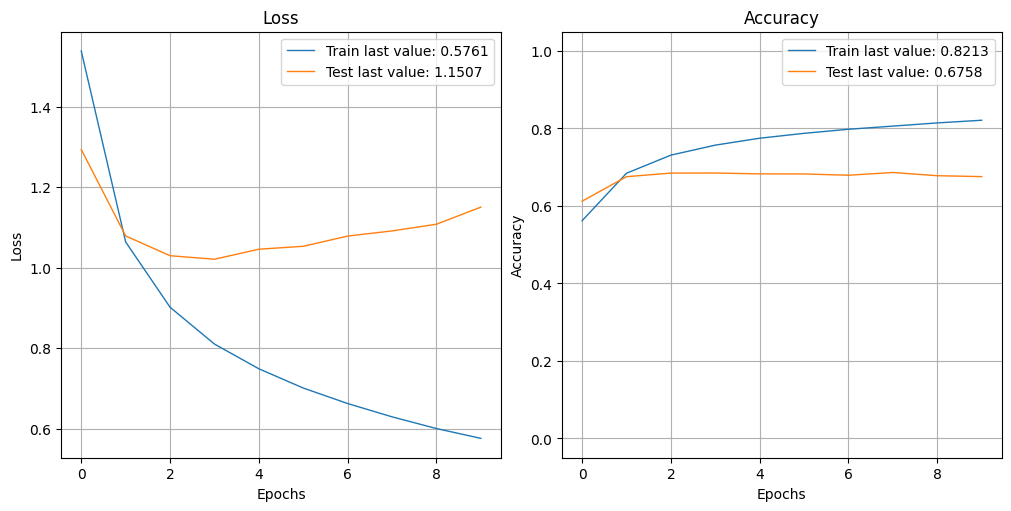

In [29]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

print("Overall Accuracy:", score[1]*100)
plot_history(history.history,path = "std.png")
plt.show()

In [30]:
# Generate predictions for the test data
# Decoding dictionary
decoding_dic= {}

for i in one_hot_encoding_dic.columns:
    decoding_dic[np.argmax(one_hot_encoding_dic[i])] = i

Classes_names = []
for i in range(len(decoding_dic.items())):
    Classes_names.append(decoding_dic[i])
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

560/560 [==============================] - 111s 195ms/step


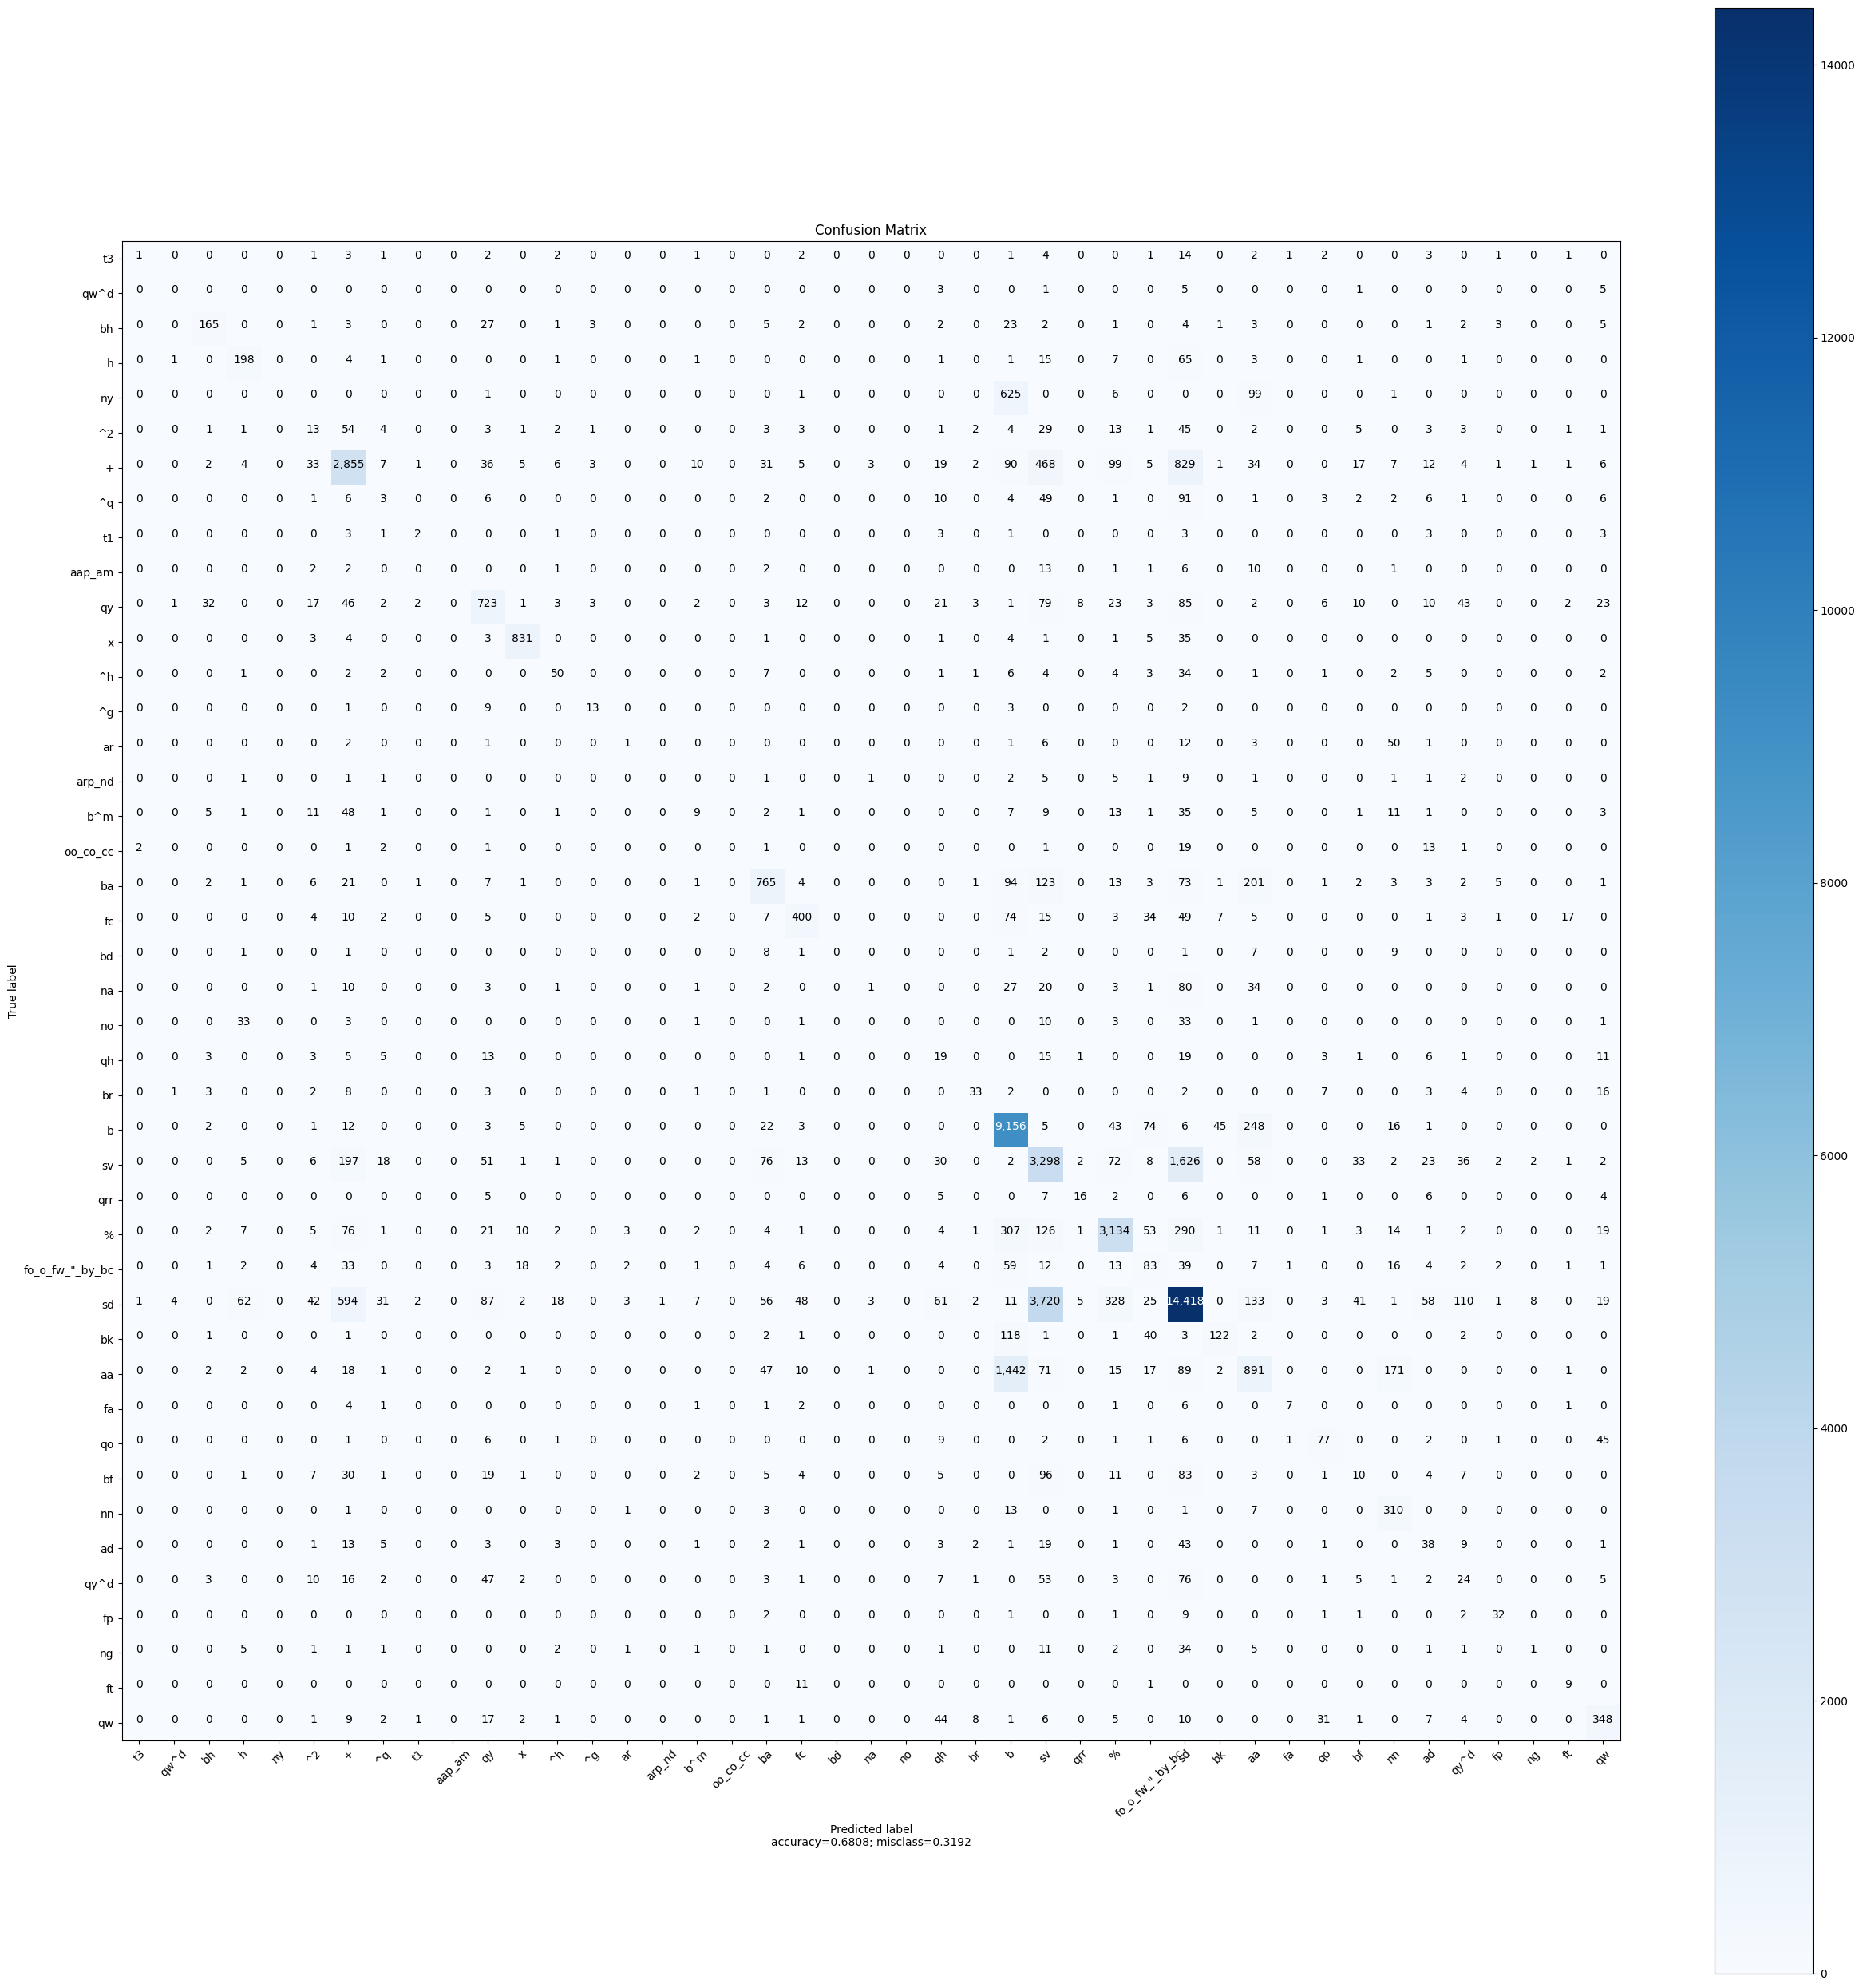

In [31]:
test_predictions = model.predict(test_sentences_X, batch_size = 100)
rounded_labels_Gold = np.argmax(y_test, axis=1)
rounded_labels_pred = np.argmax(test_predictions, axis=1)

# print(rounded_labels,"\n",test_predictions)
cm=sklearn.metrics.confusion_matrix(rounded_labels_Gold,rounded_labels_pred)
plot_confusion_matrix(cm,normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")

In [32]:
# Calculate Accuracies for "br" and "bf"
def Cal_Accuracy_Minority(class_name,ConfusionMatrix):
    # Finding position of class in confusion Matrix
    Position = np.argmax(one_hot_encoding_dic[class_name])
    print('Position:',Position)
    # Finding True positive
    TP_minority = ConfusionMatrix[Position][Position]
    # Total instances
    instances = 0 
    for i in range(len(ConfusionMatrix)):
        instances += ConfusionMatrix[Position][i]
    print('Instance :', instances)
    # Accuracy
    Accuracy_min = TP_minority/instances
    return Accuracy_min

# Calculate Accuracies for "br" and "bf" for imbalanced data
accuracy_br = Cal_Accuracy_Minority('br',cm)
accuracy_bf = Cal_Accuracy_Minority('bf',cm)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)

Position: 24
Instance : 86
Position: 35
Instance : 290
accuracy of br is : 0.38372093023255816
accuracy of bf is : 0.034482758620689655


In [33]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


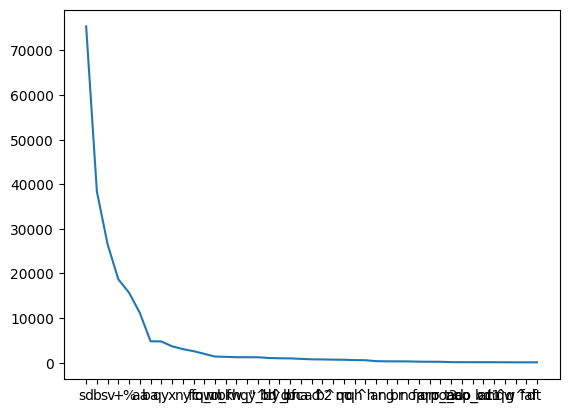

In [34]:
# Plot the frequencies of the classes
plt.plot(value_counts)

In [35]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

In [36]:
# Re-built the model for the balanced training
model_balanced = Sequential(
    [
     Embedding(mask_zero = False, input_dim = VOCAB_SIZE + 1, output_dim = EMBED_SIZE, input_length = MAX_LENGTH, embeddings_initializer='glorot_uniform'),
     Bidirectional(LSTM(43, return_sequences = True)),
     Bidirectional(LSTM(43, return_sequences = False)),
     Dense(HIDDEN_SIZE),
     Activation('softmax')
    ]
)
model_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_balanced.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          4373300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 43)                3741      
                                                                 
 activation_1 (Activation)   (None, 43)                0         
                                                                 
Total params: 4,471,297
Trainable params: 4,471,297
No

In [37]:
# Train the balanced network - Seems to take long time to achieve good accuracy?
history = model_balanced.fit(train_input,
                    train_labels,
                    epochs=10,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    class_weight = d_class_weights,
                    verbose=1)

Epoch 1/10
547/547 [==============================] - 804s 1s/step - loss: 3.1448 - accuracy: 0.2397 - val_loss: 2.5082 - val_accuracy: 0.3533
Epoch 2/10
547/547 [==============================] - 818s 1s/step - loss: 2.3286 - accuracy: 0.3374 - val_loss: 2.3161 - val_accuracy: 0.3496
Epoch 3/10
547/547 [==============================] - 817s 1s/step - loss: 1.8982 - accuracy: 0.3811 - val_loss: 2.1635 - val_accuracy: 0.3626
Epoch 4/10
547/547 [==============================] - 808s 1s/step - loss: 1.6032 - accuracy: 0.3982 - val_loss: 2.1450 - val_accuracy: 0.3509
Epoch 5/10
547/547 [==============================] - 771s 1s/step - loss: 1.3989 - accuracy: 0.4315 - val_loss: 2.1010 - val_accuracy: 0.3526
Epoch 6/10
547/547 [==============================] - 807s 1s/step - loss: 1.2175 - accuracy: 0.4623 - val_loss: 2.1198 - val_accuracy: 0.3486
Epoch 7/10
547/547 [==============================] - 806s 1s/step - loss: 1.0929 - accuracy: 0.4769 - val_loss: 1.8192 - val_accuracy: 0.4308

In [38]:
# Overall Accuracy
score = model_balanced.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 127s 227ms/step - loss: 1.9134 - accuracy: 0.4215


In [39]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 42.1505481004715


Overall Accuracy: 42.1505481004715


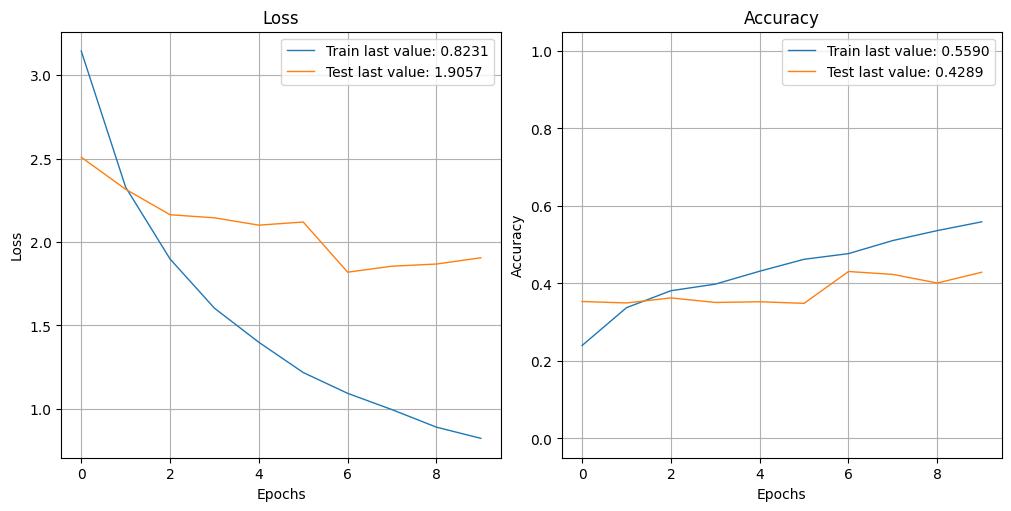

In [40]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

print("Overall Accuracy:", score[1]*100)
plot_history(history.history,path = "std.png")
plt.show()

In [41]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_sentences_X, batch_size=100)

560/560 [==============================] - 124s 218ms/step


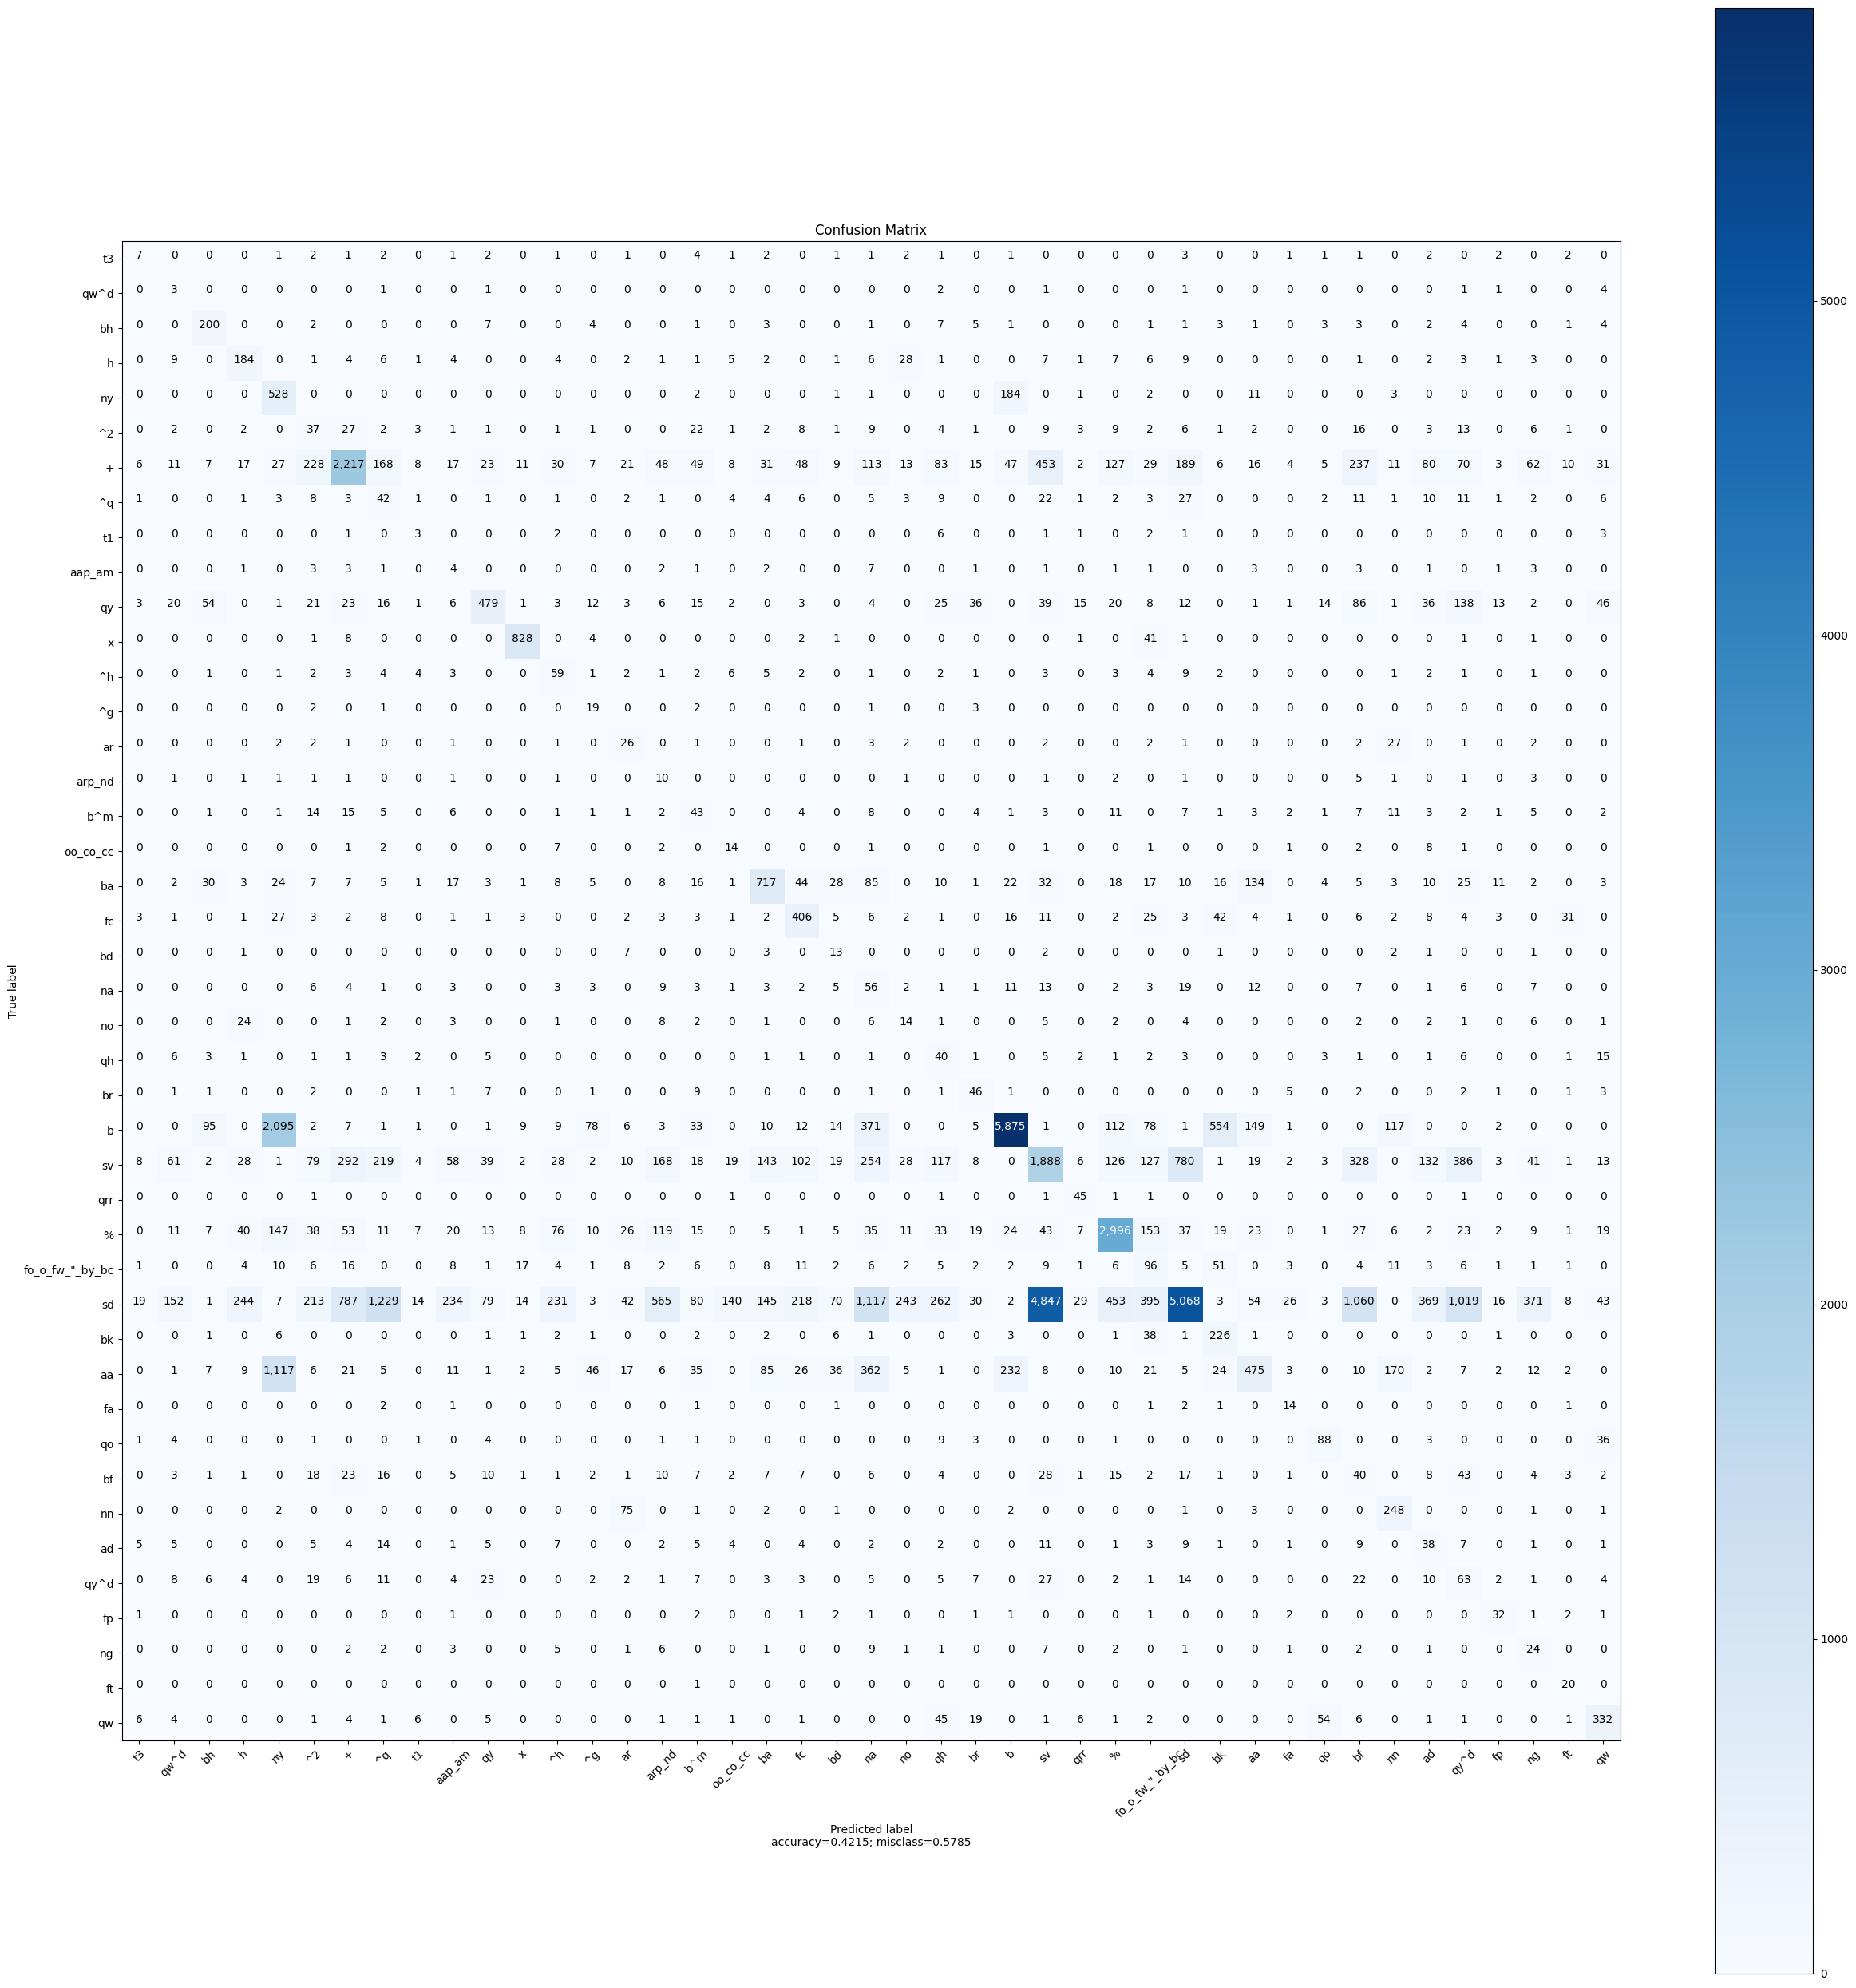

Position: 24
Instance : 86
Position: 35
Instance : 290
accuracy of br is : 0.5348837209302325
accuracy of bf is : 0.13793103448275862


In [42]:
# Build the confusion matrix off these predictions
matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))
plot_confusion_matrix(matrix_balanced,normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")
# Calculate Accuracies for "br" and "bf"
accuracy_br = Cal_Accuracy_Minority('br',matrix_balanced)
accuracy_bf = Cal_Accuracy_Minority('bf',matrix_balanced)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)

In [43]:
from keras.layers import Input, Reshape, Conv2D, BatchNormalization, MaxPool2D, concatenate, Flatten, TimeDistributed
from keras import Model
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = 150
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
concatenated_tensors = concatenate([maxpool_0, maxpool_1, maxpool_2])
# flatten concatenated tensors
flattened_tensors = TimeDistributed(Flatten())(concatenated_tensors)
# dense layer (dense_1)
dense_1 = Dense(EMBED_SIZE, activation='relu')(flattened_tensors)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)

In [44]:
# BLSTM model

# Bidirectional 1
Bidirectional_1=Bidirectional(LSTM(EMBED_SIZE,return_sequences=True))(dropout_1)
# Bidirectional 2
Bidirectional_2=Bidirectional(LSTM(EMBED_SIZE,return_sequences=False))(Bidirectional_1)
# Dense layer (dense_2)
dense_2=Dense(EMBED_SIZE, activation='softmax')(Bidirectional_2)
flattened_layer = Flatten()(dropout_1)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)

In [45]:
# concatenate 2 final layers
a=concatenate([flattened_layer,dropout_2])
dense_layer = Dense(43, activation = 'softmax')(a)
# output
output = Model(inputs=inputs, outputs=dense_layer)
output.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
output.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 150, 100)     4373200     ['input_3[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 150, 100, 1)  0           ['embedding_2[0][0]']            
                                                                                                  
 conv2d (Conv2D)                (None, 148, 1, 64)   19264       ['reshape[0][0]']                
                                                                                            

## **Part E**

In [102]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)

In [106]:
!unzip -q cornell-movie-corpus-legacy.zip

In [107]:
#Loading the data
lines = open('movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

In [108]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]

In [109]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


In [110]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [111]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len

14500

In [112]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [113]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

 : [------------------->] 100%
Trimmed from 145905 pairs to 114938


114938

In [114]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

114938

In [116]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-04-24 07:04:52--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-24 07:04:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2023-04-24 07:07:32 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [117]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [118]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding mtrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test)

Loading glove...
GloVe  50  loded!


In [119]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units
        self.embeddings = embeddings

        #  pass the embedding into a bidirectional version of the GRU
        #                                                                                        
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions

        self.Bidirectional1 = Bidirectional(GRU(self.enc_units, return_state= False, return_sequences= True, recurrent_initializer = 'glorot_uniform'))
        self.Bidirectional2 = Bidirectional(GRU(self.enc_units, return_state= True, return_sequences= True, recurrent_initializer = 'glorot_uniform'))
            
    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):

        x = self.embeddings(x)
        x = self.dropout(x) # dropout 1
        x = self.Bidirectional1(x)
        x = self.dropout(x) # dropout 2
        x = self.Bidirectional2(x)
        output, state_f,state_b = x

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [120]:
encoder = Encoder(vocab_len, 50, GRU_units)

In [121]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [122]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        self.dropout = Dropout(0.2)
        # Create the decoder with attention

        self.attention = BahdanauAttention(self.units)

        self.decoder_gru_l1 = Bidirectional(GRU(self.units, return_sequences=True, return_state=False, recurrent_initializer = 'glorot_uniform'))
        self.decoder_gru_l2 = (GRU(self.units, return_sequences=False, return_state=True, recurrent_initializer = 'glorot_uniform'))


    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        x = self.decoder_gru_l2(x)
        output, state = x
        x = self.fc(output)
        return x, state, attention_weights

In [123]:
decoder = Decoder(vocab_len, 50, GRU_units)

In [124]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

In [125]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

In [126]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [127]:
 checkpoint_dir = '/content'
checkpoint_prefix = os.path.join(str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [128]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [129]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 150 
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1

In [130]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

In [131]:
checkpoint.restore(str(emb_dim)+"-ckpt-60")# last save 60
current_ep = 60

NotFoundError: ignored

In [132]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Epoch 1 Batch 598 Loss: 2.0988
Epoch 1 Batch 1196 Loss: 2.3231
Epoch 1 Batch 1794 Loss: 2.1232
Epoch 1 Batch 2392 Loss: 2.0922


KeyboardInterrupt: ignored

In [ ]:
checkpoint.restore(str(emb_dim)+"-ckpt-150")

In [ ]:
test_bot()

In [ ]:
q = "How old are you"
answer(q, training=False)

In [ ]:
q = "Do you drink"
answer(q, training=False)